In [1]:
import os
import random
import math
import time
import uuid
import sys
import copy
import datetime

from tqdm.notebook import tqdm
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, losses, initializers, constraints, backend

from tensorflow.keras.preprocessing.image import save_img

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

try:
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [3]:
print(tf.executing_eagerly())

True


### Defining models global variables

In [4]:
IMG_SIDE_LENGTH = 64

var_scale = 0.02
init_norm = initializers.RandomNormal(mean=0., stddev=var_scale)

### Defining an additional class for weight clipping that is used in Wasserstein GAN training algorithm

In [5]:
class WeightClip(constraints.Constraint):
    '''
    Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, c=0.01):
        self.c = c

    def __call__(self, val):
        return backend.clip(val, -self.c, self.c)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'c': self.c}

## Building the Critic

- Use a linear activation function in the output layer of the critic model (instead of sigmoid).

- Constrain critic model weights to a limited range after each mini batch update (e.g. [-0.01,0.01]).

- First layer of the discriminator is not batch normalized, so that the model can learn the correct mean and scale of the data distribution.

In [6]:
def build_critic(w_init=None, clip_value=0.01):
    C = models.Sequential(name="Critic")
    
    #### 1st convolutional layer ####
    C.add(layers.Conv2D(32, (3, 3), strides=(1, 1),
                        input_shape=(IMG_SIDE_LENGTH, IMG_SIDE_LENGTH, 3),
                        kernel_initializer=w_init,
                        kernel_constraint=WeightClip(clip_value)))
    ## leaky relu ##
    C.add(layers.LeakyReLU())
    
    #### 2nd convolutional layer ####
    C.add(layers.Conv2D(64, (4, 4), strides=(2, 2),
                        input_shape=(IMG_SIDE_LENGTH, IMG_SIDE_LENGTH, 3),
                        kernel_initializer=w_init,
                        kernel_constraint=WeightClip(clip_value)))
    ## leaky relu ##
    C.add(layers.LeakyReLU())
    
    ## batch normalization ##
    C.add(layers.BatchNormalization())
    
    #### 3rd convolutional layer ####
    C.add(layers.Conv2D(128, (4, 4), strides=(2, 2),
                        kernel_initializer=w_init,
                        kernel_constraint=WeightClip(clip_value)))
    ## leaky relu ##
    C.add(layers.LeakyReLU())
    ## batch normalization ##
    C.add(layers.BatchNormalization())
    
    #### 4th convolutional layer ####
    C.add(layers.Conv2D(256, (4, 4), strides=(2, 2),
                        kernel_initializer=w_init,
                        kernel_constraint=WeightClip(clip_value)))
    ## leaky relu ##
    C.add(layers.LeakyReLU())
    ## batch normalization
    C.add(layers.BatchNormalization())
    
    #### Flatten ####
    C.add(layers.Flatten())
    
#     #### Dense layer ####
#     C.add(layers.Dense(64, kernel_initializer=w_init,
#                           kernel_constraint=WeightClip(clip_value), bias_constraint=WeightClip(clip_value)))
#     ## leaky relu ##
#     C.add(layers.LeakyReLU())
#     ## batch normalization
#     C.add(layers.BatchNormalization())
    
    #### Dense (output) layer ####
    C.add(layers.Dense(1))
    
    return C

In [7]:
#D = build_critic()
C = build_critic(init_norm)
C.summary()
     

Model: "Critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        32832     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0    

### Building the Generator

- The last (output) layer of the generator is not batch normalized, so that the model can learn the correct mean and scale of the data distribution.

In [8]:
def build_generator(w_init=None):
    G = models.Sequential(name="Generator")
    
    #### Dense layer (transforms input noise vector) ####
    G.add(layers.Dense(8*8*256, input_shape=(100,),
                      kernel_initializer=w_init))
    ## leaky relu ##
    G.add(layers.LeakyReLU())
    
    #### Reshape ####
    G.add(layers.Reshape((8, 8, 256)))

    #### 1st Convolutional Transpose layer ####
    G.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same',
                                kernel_initializer=w_init))
    ## batch normalization
    G.add(layers.BatchNormalization())
    ## leaky relu ##
    G.add(layers.LeakyReLU())
    
    #### 2nd Convolutional Transpose layer ####
    G.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same',
                                kernel_initializer=w_init))
    ## batch normalization
    G.add(layers.BatchNormalization())
    ## leaky relu ##
    G.add(layers.LeakyReLU())

    #### 3rd Convolutional Transpose Layer ####
    G.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same',
                                kernel_initializer=w_init))
    ## batch normalization
    G.add(layers.BatchNormalization())
    ## leaky relu ##
    G.add(layers.LeakyReLU())
    
#     #### 4th Convolutional Transpose Layer ####
#     G.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same',
#                                 kernel_initializer=w_init))
#     ## batch normalization
#     G.add(layers.BatchNormalization())
#     ## leaky relu ##
#     G.add(layers.LeakyReLU())
    
    #### Output Convolutional Transpose Layer ####
    G.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh',
                                kernel_initializer=w_init))

    return G

In [9]:
G = build_generator(init_norm)
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       26

### Example of a generated image

(2, 100)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 64, 64, 3)


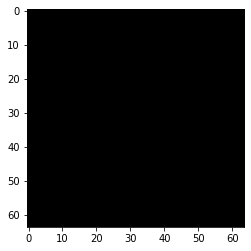

In [10]:
noise = np.random.normal(scale=var_scale, size=(2, 100))
print(noise.shape)

generated_image = np.array(G(noise, training=False))
print(generated_image.shape)

# print(generated_image[0][0][:10])

#gen_re = generated_image.reshape((224, 224, 3))
#print(gen_re.mean(), gen_re.max(), gen_re.min())

plt.imshow(generated_image[0, :, :, :])

### Example of a score by the critic

In [11]:
score = C(generated_image)
print(score)

tf.Tensor(
[[-1.8844554e-06]
 [-7.0907447e-07]], shape=(2, 1), dtype=float32)


### Defining parameters for training

In [12]:
EPOCHS = 1000
NOISE_DIM = 100
CRITIC_TRAIN_STEPS = 3
BATCH_SIZE = 240
MINIBATCH_SIZE = int(BATCH_SIZE / CRITIC_TRAIN_STEPS)
# SAVE_BATCH_SIZE = 16

alpha = 0.00005
clip_value = 0.01

critic_optimizer = optimizers.RMSprop(learning_rate=alpha)
gen_optimizer = optimizers.RMSprop(learning_rate=alpha)

### Generator Loss Function

In [13]:
def generator_loss(gen_pred):
    return -1 * backend.mean(gen_pred)

### Critic Loss Function

In [14]:
def critic_loss(real_pred, gen_pred):
    return -1 * backend.mean(real_pred - gen_pred)

## Training step

In [15]:
@tf.function
def train_step(generator, critic, images, c_iters=1):
    
    G, C = generator, critic
    C_loss = 0
    
    ## train only Critic for n steps
    for k in range(c_iters):
        
        # sample noise
        noise = tf.random.normal([MINIBATCH_SIZE, NOISE_DIM])
        
        with tf.GradientTape() as critic_tape:
            # turn noise into generated images
            gen_images = G(noise, training=False)
            # sample real images
            real_images = images[MINIBATCH_SIZE*k : MINIBATCH_SIZE*(k+1)]

            # predict
            real_pred = C(real_images, training=True)
            gen_pred = C(gen_images, training=True)

            # calculate critic loss
            C_loss += critic_loss(real_pred, gen_pred)

        # calculate critic gradients
        C_gradients = critic_tape.gradient(C_loss, C.trainable_variables)
        # update critic weights
        critic_optimizer.apply_gradients(zip(C_gradients, C.trainable_variables))
        # clip critic weights
        ## is implemented inside the critic's layers

    C_loss = C_loss / c_iters
        
    ## train only G for 1 step
    # sample noise
    noise = tf.random.normal([MINIBATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape:
        # turn noise into generated images
        gen_images = G(noise, training=True)
        # predict generated images being real
        gen_pred = C(gen_images, training=False)
        
        # calculate Generator loss
        G_loss = generator_loss(gen_pred)
        
    # calculate Generator gradients 
    G_gradients = gen_tape.gradient(G_loss, G.trainable_variables)
    # update Generator weights
    gen_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))

    return C_loss, G_loss

# Training

In [16]:
def train(epochs, dir_path, load_models=False, save_images=False, save_models=False):
    """
    load_models : boolean -------- use saved models ?
    epochs : integer -------- number of epochs
    dir_path : string -------- path to directory with .npy files
    save_images : boolean -------- save generated images ?
    save_models : boolean -------- save models ?
    """
    
    generator = build_generator(init_norm)
    critic = build_critic(init_norm, clip_value=clip_value)
    
    # load models from files if needed
    if load_models:
        try:
            generator = tf.keras.models.load_model('../models/latest/generator')
            critic = tf.keras.models.load_model('../models/latest/critic')
        except:
            print("####### Failed to load models ########")
    
    C_losses, G_losses = [], []
    
    # form a list of .npy files' paths
    np_paths = []
    
    with os.scandir(dir_path) as it:
        for file in tqdm(it):
            np_paths.append(file.path)
    
    basename = datetime.datetime.now().strftime("%d-%m-%y_%H:%M:%S")
    
    # create a dir for saving generated images
    if save_images:
        img_save_path = f"../data/generated/{basename}"
        os.mkdir(img_save_path)

    save_model_every = max(1, int(epochs / 20))
    # create a dir to save models
    if save_models:
        models_save_path = f"../models/{basename}"
        os.mkdir(models_save_path)
    
    pbar = tqdm(total=100)
    
    # training
    for ep in range(epochs):
        start = time.time()
        
        # episodic paths for random sampling
        np_paths_ep = copy.copy(np_paths)

        r = np.random.randint(len(np_paths_ep))
        real_images = np.load(np_paths_ep[r])
        np.random.shuffle(real_images)
        np_paths_ep.pop(r)
    
#         total_images_used = 0
        
        while len(real_images) >= BATCH_SIZE:
            # sample real images for the next batch
            images_batch = real_images[:BATCH_SIZE]
            # normalize the images to [-1, 1]
            images_batch = (images_batch - 127.5) / 127.5  
            # train models on current batch
            C_loss, G_loss = train_step(generator, critic, images_batch, CRITIC_TRAIN_STEPS)

            # cut off previously used batch
            real_images = real_images[BATCH_SIZE:]
            
            # load new images if needed
            while len(real_images) < BATCH_SIZE and len(np_paths_ep) > 0:
                r = np.random.randint(len(np_paths_ep))
                real_images = np.concatenate((real_images, np.load(np_paths_ep[r])))
                np.random.shuffle(real_images)
                np_paths_ep.pop(r)
                        
        C_losses.append(C_loss)
        G_losses.append(G_loss)
        
        pbar.update(round(1/epochs * 100, 2))
        
        print(f"EPOCH {ep+1}: {time.time() - start:.5f} sec")
        print(f"Critic loss: {C_losses[-1]:.5f}")
        print(f"Generator loss: {G_losses[-1]:.5f}")
        
        ## save generated image every ep
        if save_images:
            noise = tf.random.normal([1, NOISE_DIM])
            imgts = generator(noise, training=False).numpy().reshape(IMG_SIDE_LENGTH, IMG_SIDE_LENGTH, 3)
            save_img(f"{img_save_path}/{ep}.jpg", imgts)
            
        ## save model from time to time
        if save_models and ep % save_model_every == 0:
            generator.save(f"{models_save_path}/generator")
            critic.save(f"{models_save_path}/critic")
            
    pbar.close()
    
    return C_losses, G_losses, critic, generator, basename

In [17]:
with tf.device('/GPU:0'):
    
    load_models = False
    save_models = True
    save_images = True
    C_loss, G_loss, C, G, basename = train(1000, "../data/numpy64-500", load_models=load_models,
                                    save_images=save_images, save_models=save_models)

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

EPOCH 1: 35.34962 sec
Critic loss: -279.87976
Generator loss: -498.95859
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 2: 31.15544 sec
Critic loss: -537.79456
Generator loss: -574.34271
EPOCH 3: 30.96272 sec
Critic loss: -775.19812
Generator loss: 41.55938
EPOCH 4: 30.95251 sec
Critic loss: -547.01526
Generat

EPOCH 92: 30.98343 sec
Critic loss: -29214.69531
Generator loss: 791.01672
EPOCH 93: 30.97406 sec
Critic loss: -28755.47461
Generator loss: -1364.77637
EPOCH 94: 31.01007 sec
Critic loss: -30402.19336
Generator loss: -418.91049
EPOCH 95: 30.98308 sec
Critic loss: -30060.85547
Generator loss: -1260.61353
EPOCH 96: 30.98854 sec
Critic loss: -30379.74805
Generator loss: -1405.49390
EPOCH 97: 30.98087 sec
Critic loss: -30627.15430
Generator loss: -1435.25232
EPOCH 98: 30.99755 sec
Critic loss: -33689.48828
Generator loss: -490.08447
EPOCH 99: 30.98114 sec
Critic loss: -32584.91406
Generator loss: -1025.65747
EPOCH 100: 30.97214 sec
Critic loss: -31865.17773
Generator loss: -765.19183
EPOCH 101: 31.00262 sec
Critic loss: -35092.69531
Generator loss: -701.23865
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 102: 30.96307 sec
Critic loss: -32750.25391
Generator loss: -1655.89807

EPOCH 194: 31.02125 sec
Critic loss: -106025.89062
Generator loss: -6976.06543
EPOCH 195: 30.96091 sec
Critic loss: -108515.21094
Generator loss: 5854.84375
EPOCH 196: 30.98081 sec
Critic loss: -111101.05469
Generator loss: -10317.81543
EPOCH 197: 30.99002 sec
Critic loss: -114401.71094
Generator loss: -7235.47119
EPOCH 198: 31.00156 sec
Critic loss: -111531.21094
Generator loss: -9357.24902
EPOCH 199: 30.98168 sec
Critic loss: -115179.64062
Generator loss: -11567.84766
EPOCH 200: 30.98853 sec
Critic loss: -113722.92188
Generator loss: -6311.12793
EPOCH 201: 30.98506 sec
Critic loss: -115707.73438
Generator loss: -10445.09570
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 202: 30.96415 sec
Critic loss: -119124.76562
Generator loss: -6757.91260
EPOCH 203: 30.96700 sec
Critic loss: -108942.92969
Generator loss: -8188.91260
EPOCH 204: 30.97631 sec
Critic loss: -111647.37500


EPOCH 294: 30.99584 sec
Critic loss: -225590.96875
Generator loss: -13457.40039
EPOCH 295: 30.96859 sec
Critic loss: -236187.96875
Generator loss: -740.02502
EPOCH 296: 30.97668 sec
Critic loss: -219832.75000
Generator loss: -4619.71582
EPOCH 297: 30.98519 sec
Critic loss: -227345.09375
Generator loss: -24447.18555
EPOCH 298: 30.99371 sec
Critic loss: -240432.71875
Generator loss: 6030.64893
EPOCH 299: 30.99366 sec
Critic loss: -232027.90625
Generator loss: -12027.43164
EPOCH 300: 30.99962 sec
Critic loss: -259191.79688
Generator loss: -471.72968
EPOCH 301: 30.96963 sec
Critic loss: -234304.92188
Generator loss: -20758.97266
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 302: 30.96897 sec
Critic loss: -240927.90625
Generator loss: 681.86719
EPOCH 303: 30.94353 sec
Critic loss: -234286.71875
Generator loss: -13124.77539
EPOCH 304: 30.95597 sec
Critic loss: -242708.18750
Ge

EPOCH 394: 30.96342 sec
Critic loss: -403387.06250
Generator loss: 20644.90625
EPOCH 395: 30.94741 sec
Critic loss: -420858.09375
Generator loss: -15591.40430
EPOCH 396: 30.95971 sec
Critic loss: -406247.81250
Generator loss: -13363.20605
EPOCH 397: 30.95326 sec
Critic loss: -411821.75000
Generator loss: -39543.60156
EPOCH 398: 30.96794 sec
Critic loss: -457725.34375
Generator loss: 57509.53125
EPOCH 399: 30.94733 sec
Critic loss: -425676.00000
Generator loss: -8908.56445
EPOCH 400: 30.95847 sec
Critic loss: -411194.00000
Generator loss: -18244.22070
EPOCH 401: 30.94935 sec
Critic loss: -415981.59375
Generator loss: -2170.80176
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 402: 30.95462 sec
Critic loss: -424666.00000
Generator loss: 2891.84912
EPOCH 403: 30.94232 sec
Critic loss: -423125.43750
Generator loss: -7472.69678
EPOCH 404: 30.94311 sec
Critic loss: -419282.37500

EPOCH 494: 30.97195 sec
Critic loss: -643043.37500
Generator loss: -20856.15430
EPOCH 495: 30.95603 sec
Critic loss: -639218.93750
Generator loss: -26632.45703
EPOCH 496: 30.94454 sec
Critic loss: -628514.37500
Generator loss: 1386.29333
EPOCH 497: 30.95733 sec
Critic loss: -624550.43750
Generator loss: 2019.35779
EPOCH 498: 30.96550 sec
Critic loss: -570931.75000
Generator loss: -17617.92383
EPOCH 499: 30.94299 sec
Critic loss: -626863.50000
Generator loss: -18636.64062
EPOCH 500: 30.94882 sec
Critic loss: -641230.43750
Generator loss: 34815.92188
EPOCH 501: 30.95553 sec
Critic loss: -648038.75000
Generator loss: 12205.84570
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 502: 30.97301 sec
Critic loss: -622948.62500
Generator loss: -1807.22144
EPOCH 503: 30.95189 sec
Critic loss: -639127.00000
Generator loss: 13149.61133
EPOCH 504: 30.95128 sec
Critic loss: -663270.00000


EPOCH 594: 30.94272 sec
Critic loss: -990709.18750
Generator loss: -46051.60938
EPOCH 595: 30.96648 sec
Critic loss: -984745.12500
Generator loss: 7384.04150
EPOCH 596: 30.95775 sec
Critic loss: -851851.50000
Generator loss: 50055.30469
EPOCH 597: 30.96480 sec
Critic loss: -1021032.50000
Generator loss: -58959.77344
EPOCH 598: 30.94374 sec
Critic loss: -909547.68750
Generator loss: -43588.44922
EPOCH 599: 30.97616 sec
Critic loss: -914244.50000
Generator loss: -36437.09766
EPOCH 600: 30.94900 sec
Critic loss: -876457.00000
Generator loss: 21502.08203
EPOCH 601: 30.94115 sec
Critic loss: -904658.37500
Generator loss: 65342.50000
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 602: 30.96836 sec
Critic loss: -872789.68750
Generator loss: 14651.04883
EPOCH 603: 30.94639 sec
Critic loss: -965846.93750
Generator loss: -57664.82422
EPOCH 604: 30.94136 sec
Critic loss: -913249.937

EPOCH 693: 30.92967 sec
Critic loss: -1179206.25000
Generator loss: -43629.87500
EPOCH 694: 30.95148 sec
Critic loss: -1185066.00000
Generator loss: -23036.18750
EPOCH 695: 30.96550 sec
Critic loss: -1202058.75000
Generator loss: -16784.54688
EPOCH 696: 30.94041 sec
Critic loss: -1197717.50000
Generator loss: 22967.68750
EPOCH 697: 30.94510 sec
Critic loss: -1187665.50000
Generator loss: -49828.24219
EPOCH 698: 30.93926 sec
Critic loss: -1186492.00000
Generator loss: -32270.83789
EPOCH 699: 30.95391 sec
Critic loss: -1191604.75000
Generator loss: -78186.79688
EPOCH 700: 30.94979 sec
Critic loss: -1181940.50000
Generator loss: -80972.14062
EPOCH 701: 30.93525 sec
Critic loss: -1228184.75000
Generator loss: 44615.05469
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/critic/assets
EPOCH 702: 30.93625 sec
Critic loss: -1781138.37500
Generator loss: 105526.62500
EPOCH 703: 30.96988 sec
Critic loss

EPOCH 791: 30.95655 sec
Critic loss: -1533732.00000
Generator loss: 66307.42188
EPOCH 792: 30.92886 sec
Critic loss: -2755513.00000
Generator loss: -165514.32812
EPOCH 793: 30.93679 sec
Critic loss: -1639776.87500
Generator loss: -16777.15625
EPOCH 794: 30.93537 sec
Critic loss: -2776837.00000
Generator loss: 41472.74609
EPOCH 795: 30.96284 sec
Critic loss: -3051070.00000
Generator loss: -3160.11865
EPOCH 796: 30.96207 sec
Critic loss: -1720554.75000
Generator loss: -13608.61914
EPOCH 797: 30.93716 sec
Critic loss: -1548897.37500
Generator loss: 45796.39062
EPOCH 798: 30.93763 sec
Critic loss: -2945947.50000
Generator loss: -165993.29688
EPOCH 799: 30.96111 sec
Critic loss: -1563476.00000
Generator loss: 33940.06641
EPOCH 800: 30.93941 sec
Critic loss: -1583534.37500
Generator loss: 72.60195
EPOCH 801: 30.93464 sec
Critic loss: -2752376.50000
Generator loss: -22147.82227
INFO:tensorflow:Assets written to: ../models/03-05-21_19:57:13/generator/assets
INFO:tensorflow:Assets written to: .

EPOCH 889: 30.93712 sec
Critic loss: -1923904.75000
Generator loss: 122000.92188
EPOCH 890: 30.94826 sec
Critic loss: -1935780.75000
Generator loss: 166927.90625
EPOCH 891: 30.94219 sec
Critic loss: -1960601.50000
Generator loss: 55906.01953
EPOCH 892: 30.97920 sec
Critic loss: -1927311.75000
Generator loss: 189973.57812
EPOCH 893: 30.95223 sec
Critic loss: -1946925.50000
Generator loss: 125262.96094
EPOCH 894: 30.94304 sec
Critic loss: -1958569.50000
Generator loss: 247114.04688
EPOCH 895: 30.92509 sec
Critic loss: -1995395.75000
Generator loss: -243317.07812
EPOCH 896: 30.95612 sec
Critic loss: -2003163.37500
Generator loss: -184491.07812
EPOCH 897: 30.94587 sec
Critic loss: -1930503.37500
Generator loss: 3111.01709
EPOCH 898: 30.93867 sec
Critic loss: -1946574.00000
Generator loss: 324633.75000
EPOCH 899: 30.95284 sec
Critic loss: -1994617.00000
Generator loss: 5447.06982
EPOCH 900: 30.94287 sec
Critic loss: -2026572.25000
Generator loss: 75722.62500
EPOCH 901: 30.94303 sec
Critic l

EPOCH 987: 30.95165 sec
Critic loss: -2456965.00000
Generator loss: 107752.73438
EPOCH 988: 30.99133 sec
Critic loss: -4499607.00000
Generator loss: -2067835.25000
EPOCH 989: 30.95818 sec
Critic loss: -4748351.50000
Generator loss: -1075838.75000
EPOCH 990: 30.96277 sec
Critic loss: -4625330.00000
Generator loss: -1044618.18750
EPOCH 991: 30.96847 sec
Critic loss: -4804765.50000
Generator loss: -1493495.75000
EPOCH 992: 30.99225 sec
Critic loss: -4648777.00000
Generator loss: -837541.68750
EPOCH 993: 30.94955 sec
Critic loss: -4676271.00000
Generator loss: -1112972.00000
EPOCH 994: 30.95824 sec
Critic loss: -2414938.00000
Generator loss: 142322.06250
EPOCH 995: 30.94871 sec
Critic loss: -2366419.00000
Generator loss: 116583.95312
EPOCH 996: 30.96207 sec
Critic loss: -2416334.50000
Generator loss: 161114.56250
EPOCH 997: 30.94332 sec
Critic loss: -2435480.75000
Generator loss: 94315.14062
EPOCH 998: 30.95204 sec
Critic loss: -2403038.50000
Generator loss: 84228.92969
EPOCH 999: 30.94041

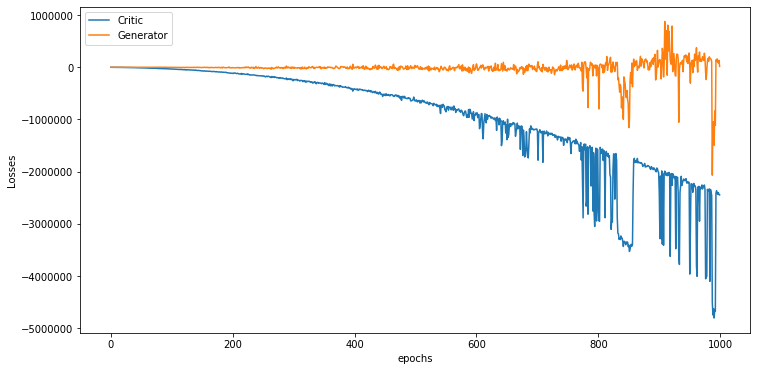

In [18]:
fig = plt.figure(figsize=(12,6))
x_epochs = range(0, len(C_loss))

for l in [C_loss, G_loss]:
    plt.plot(x_epochs, l)
    
plt.ylabel('Losses')
plt.xlabel('epochs')
plt.legend(['Critic', 'Generator'])
plt.savefig(f'../plots/{basename}.jpg')

In [19]:
# G = tf.keras.models.load_model("../models/latest/generator")
# noise = tf.random.normal([1, 100])
# # print(noise)
# generated_image = np.array(G(noise, training=False))
# print(generated_image.min(), generated_image.max(), generated_image.mean())
# plt.imshow(generated_image[0, :, :, :])